<a href="https://colab.research.google.com/github/samer-glitch/Leveraging-Machine-Learning-for-Identifying-and-Classifying-Cyber-Threats-in-Network-Environments/blob/main/Using%20different%20approach%20of%20preprocessing_RandomForestClassifier-AdaBoostClassifier-GradientBoostingClassifier-Bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()


Saving Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv


Dataset Loaded - Time Elapsed: 0:00:00.000145
Labeling Function Applied - Time Elapsed: 0:00:10.591174
Categorical Labels Encoded - Time Elapsed: 0:00:10.594180
Features and Target Variable Defined - Time Elapsed: 0:00:10.597906
Data Split into Train and Test Sets - Time Elapsed: 0:00:10.606028
Non-numeric Columns Handled - Time Elapsed: 0:00:10.611037
Preprocessing Applied - Time Elapsed: 0:00:10.626324
Classifiers Fitted - Time Elapsed: 0:00:15.472861


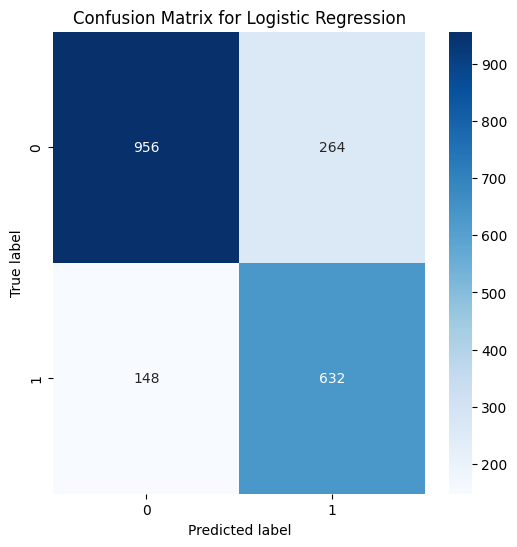

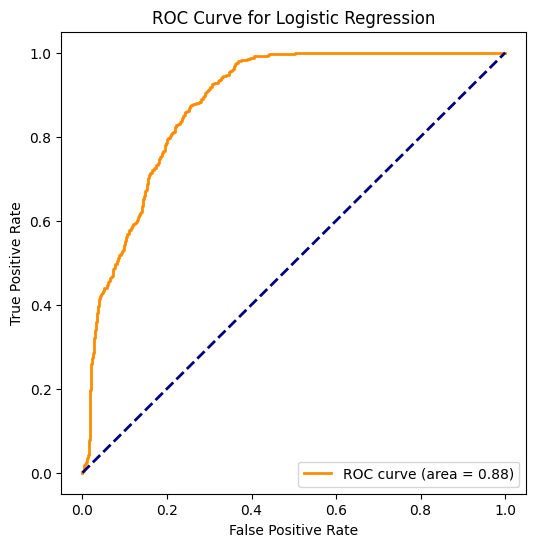

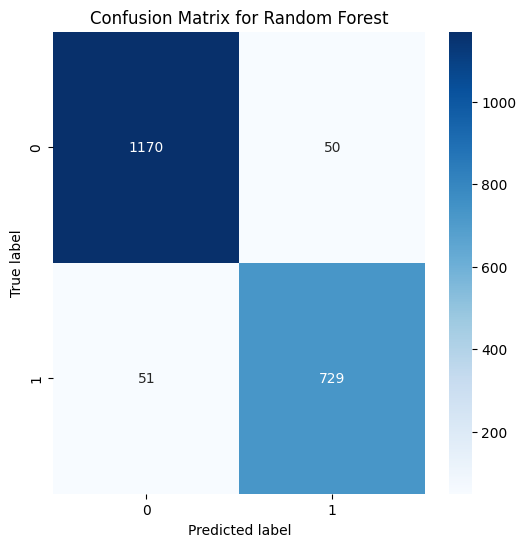

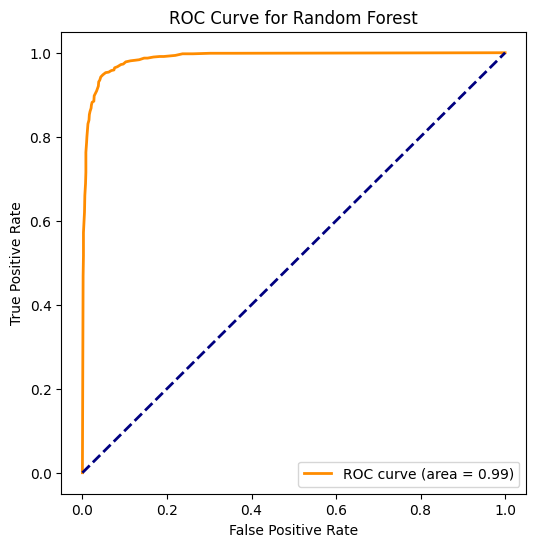

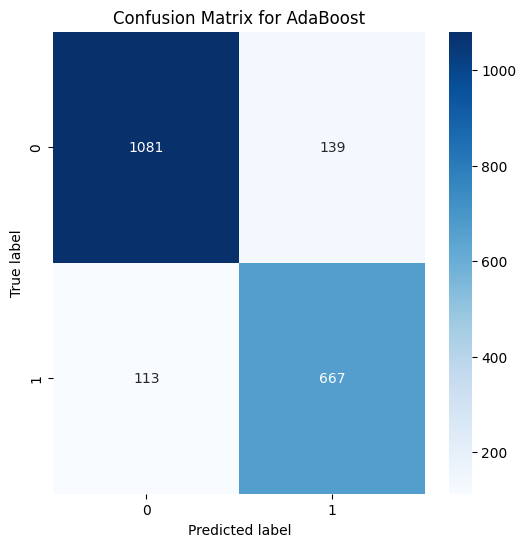

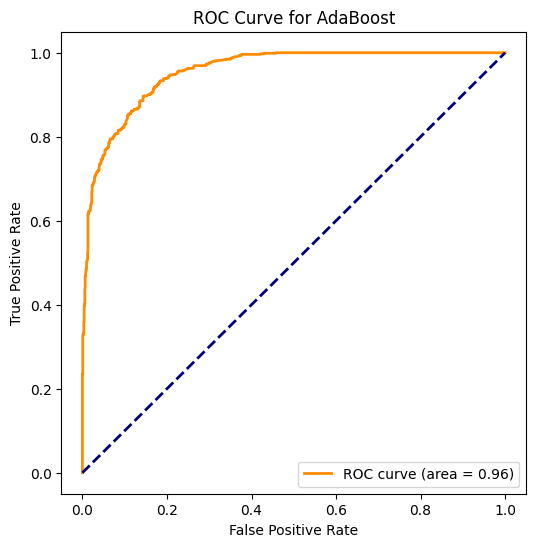

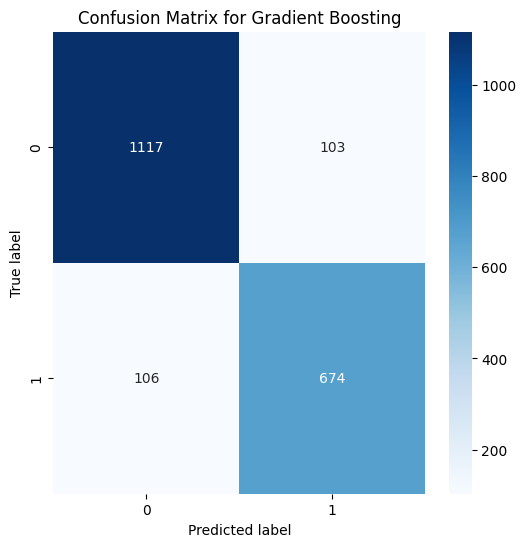

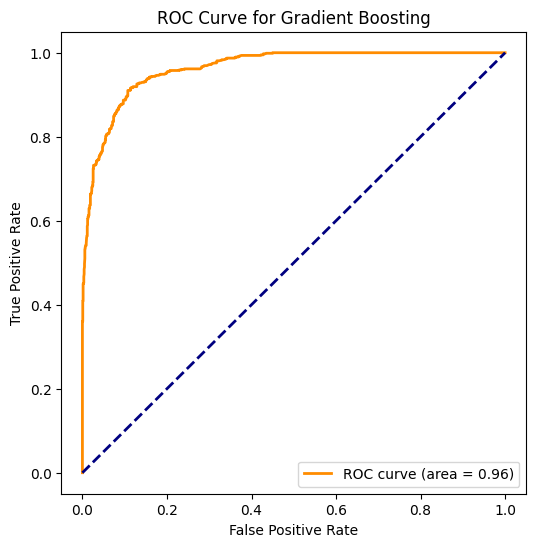


Logistic Regression Classifier:
Accuracy: 0.794 
F1-Score: 0.7541766109785203

Random Forest Classifier:
Accuracy: 0.9495 
F1-Score: 0.9352148813341885

AdaBoost Classifier:
Accuracy: 0.874 
F1-Score: 0.8411097099621688

Gradient Boosting Classifier:
Accuracy: 0.8955 
F1-Score: 0.865767501605652

Process Completed - Time: 0:00:17.930031


In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')

# Start the overall timer
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'Mining', 'VPN', 'RemoteAccess']
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df
# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Encoding the categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features and target variable
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
record_time("Features and Target Variable Defined", overall_start_time)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns

# Remove non-numeric columns for simplicity
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)
record_time("Non-numeric Columns Handled", overall_start_time)

# Apply preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit the classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


In [6]:
# Method 1: Value Counts
print("Class distribution in y:")
print(y.value_counts())

print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Method 2: Unique Values
print("\nUnique classes in y:")
print(np.unique(y))

print("\nUnique classes in y_train:")
print(np.unique(y_train))


Class distribution in y:
0    6100
1    3900
Name: category_encoded, dtype: int64

Class distribution in y_train:
0    4880
1    3120
Name: category_encoded, dtype: int64

Unique classes in y:
[0 1]

Unique classes in y_train:
[0 1]


In [7]:
print("Class distribution in full dataset:", df['traffic_label'].value_counts())
#  the class distribution in your dataset is as follows:
# Class 0: 6,100 instances
# Class 1: 3,900 instances
# This distribution indicates a slight imbalance but is not severely skewed. Generally, techniques like ADASYN (Adaptive Synthetic Sampling) or SMOTE (Synthetic Minority Over-sampling Technique) are used when there is a significant imbalance in the class distribution, which can lead the model to be biased towards the majority class.
# Considering the following aspects can help you decide whether to apply these techniques:
# Degree of Imbalance: The Dataset shows a moderate imbalance. Whether this warrants the use of ADASYN or SMOTE depends on the performance of our current models. If they are performing well in terms of metrics like F1-score, precision, recall, and accuracy across both classes, we may not need to apply these techniques.
# Model Performance: Evaluate the current models on both classes. If we notice that the performance is significantly worse for the minority class, it might be an indicator to use oversampling techniques.
# Experimentation: Machine learning often involves experimentation. we can try applying ADASYN or SMOTE and compare the model performance with and without these techniques. This comparison can give us a clear idea of whether these techniques are beneficial for your specific case.
# Risk of Overfitting: Oversampling techniques can sometimes lead to overfitting, especially if the generated synthetic samples do not represent the true underlying distribution of the minority class well. It’s important to validate the model on a separate test set that has not been oversampled.
# In summary, based on the current distribution, applying ADASYN or SMOTE is not strictly necessary but could be considered

Class distribution in full dataset: malicious    6100
normal       3900
Name: traffic_label, dtype: int64


Dataset Loaded - Time Elapsed: 0:00:00.000052
Labeling Function Applied - Time Elapsed: 0:00:06.135993
Categorical Labels Encoded - Time Elapsed: 0:00:06.141994
Features and Target Variable Defined - Time Elapsed: 0:00:06.145727
Data Split into Train and Test Sets - Time Elapsed: 0:00:06.162659
Non-numeric Columns Handled - Time Elapsed: 0:00:06.168640
Preprocessing Applied - Time Elapsed: 0:00:06.189504
Classifiers Fitted - Time Elapsed: 0:00:14.542774


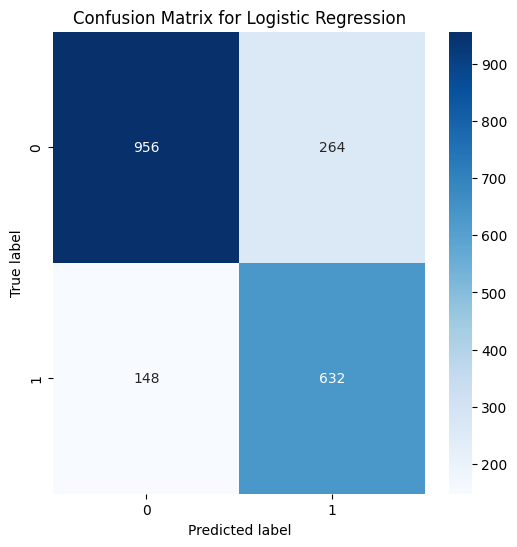

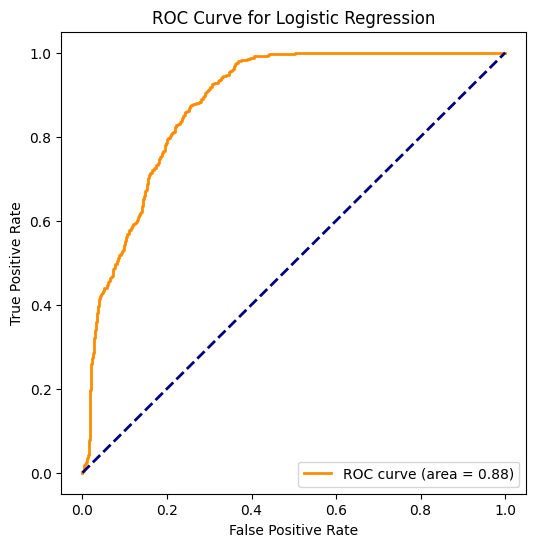

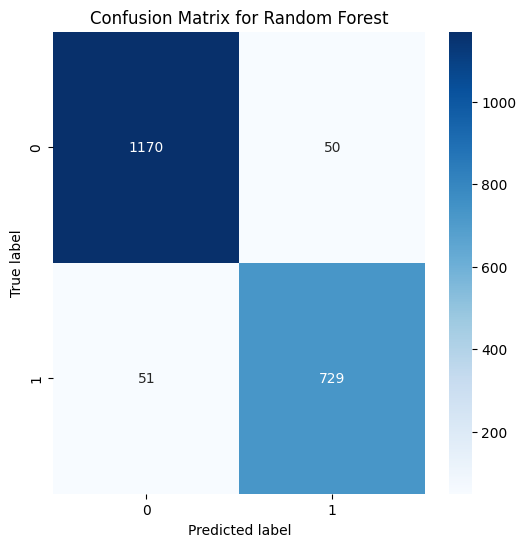

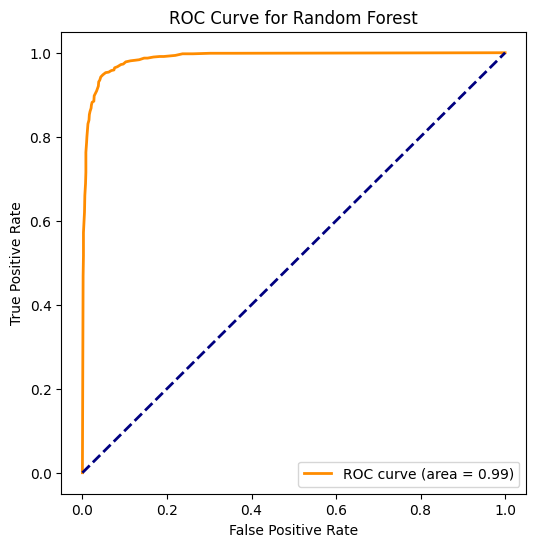

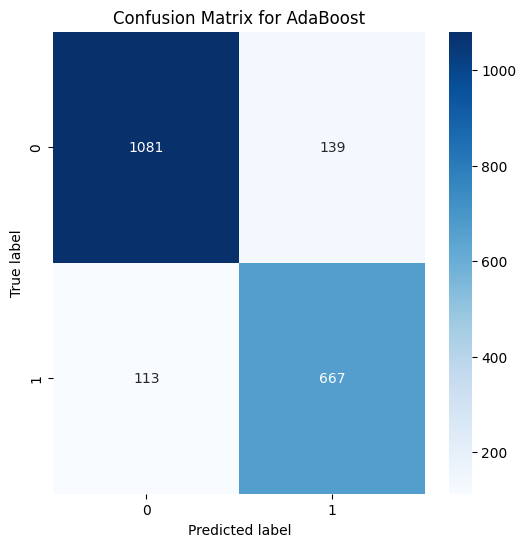

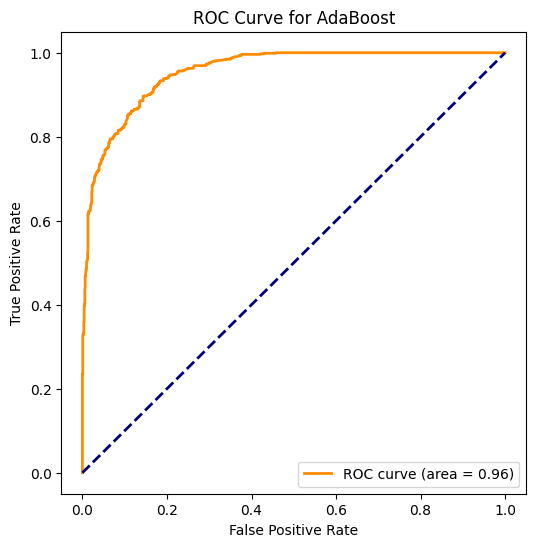

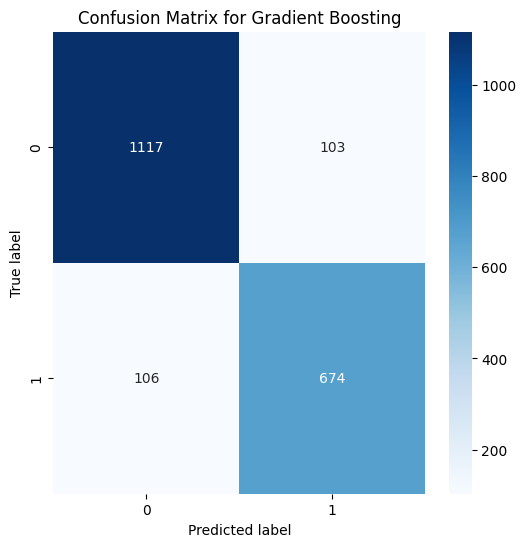

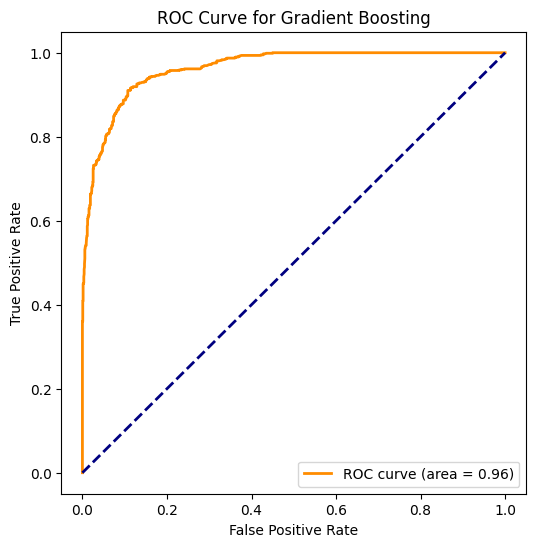


Logistic Regression Classifier:
Accuracy: 0.794 
F1-Score: 0.7541766109785203

Random Forest Classifier:
Accuracy: 0.9495 
F1-Score: 0.9352148813341885

AdaBoost Classifier:
Accuracy: 0.874 
F1-Score: 0.8411097099621688

Gradient Boosting Classifier:
Accuracy: 0.8955 
F1-Score: 0.865767501605652

Process Completed - Time: 0:00:18.421012


In [8]:
# with Hyperparameters tuning, cross validation stratisfiedKFold
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder

def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset
df = pd.read_csv('from sklearn.linear_model import LogisticRegression
.csv')

overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'Mining', 'VPN', 'RemoteAccess']
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
record_time("Features and Target Variable Defined", overall_start_time)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)
record_time("Non-numeric Columns Handled", overall_start_time)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

# Define a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
}
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}

# GridSearchCV for each classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=stratified_kfold)
ab_clf = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=param_grid_ab, cv=stratified_kfold)
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gb, cv=stratified_kfold)

# Define and fit the classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)



Dataset Loaded - Time Elapsed: 0:00:00.000075
Labeling Function Applied - Time Elapsed: 0:00:04.333894
Categorical Labels Encoded - Time Elapsed: 0:00:04.388598
Data Split into Train and Test Sets - Time Elapsed: 0:00:07.937102
Preprocessing Applied - Time Elapsed: 0:00:09.959731
Classifiers and Hyperparameter Tuning Completed - Time Elapsed: 8:44:50.988130
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


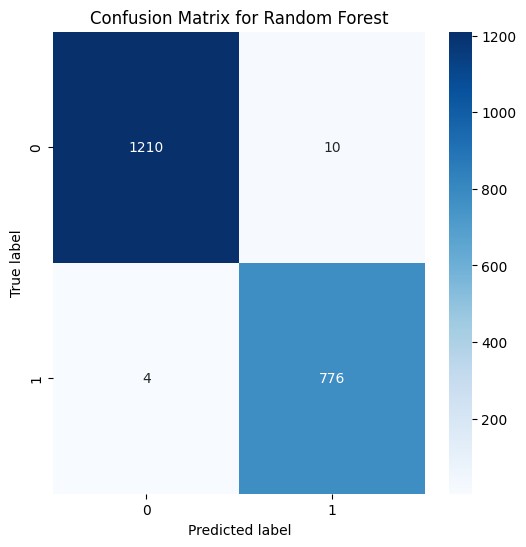

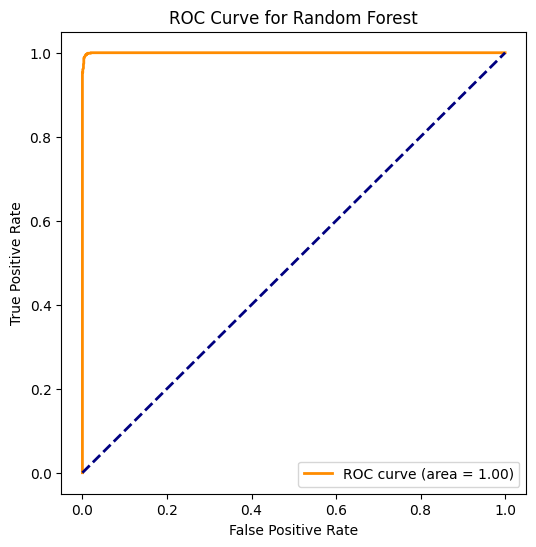

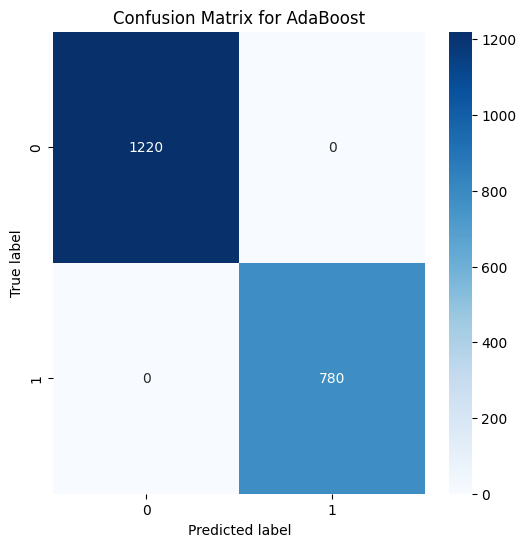

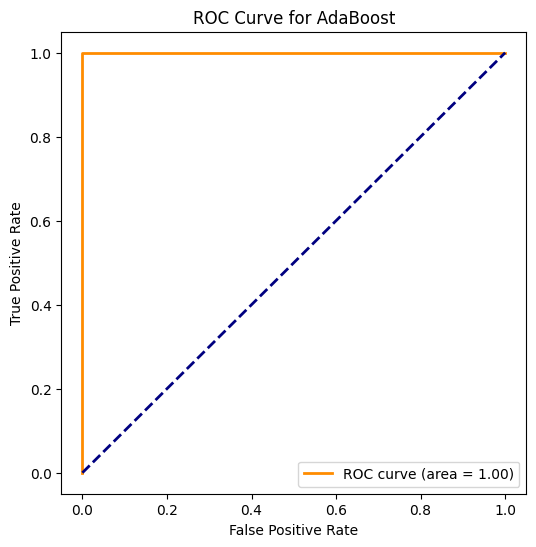

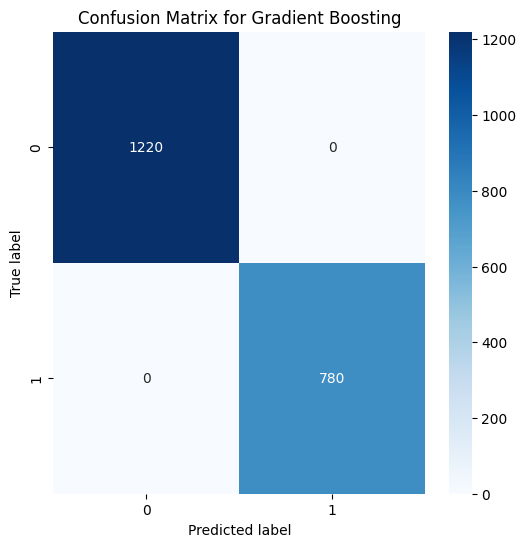

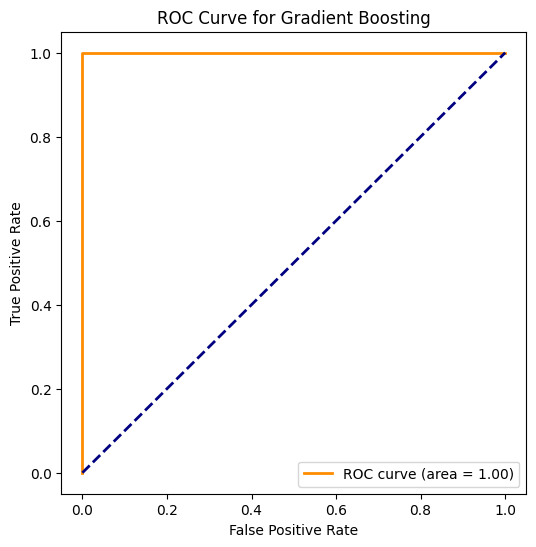

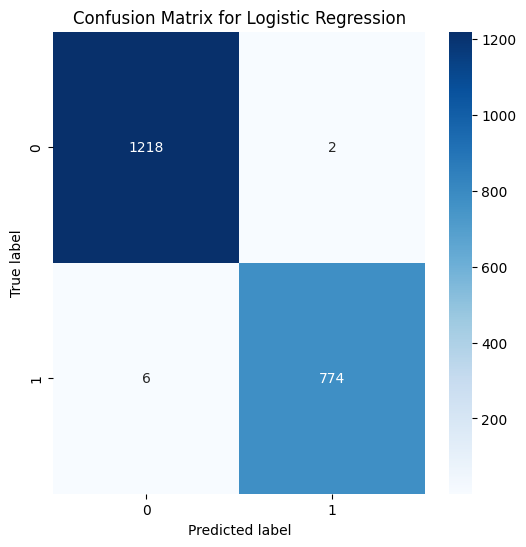

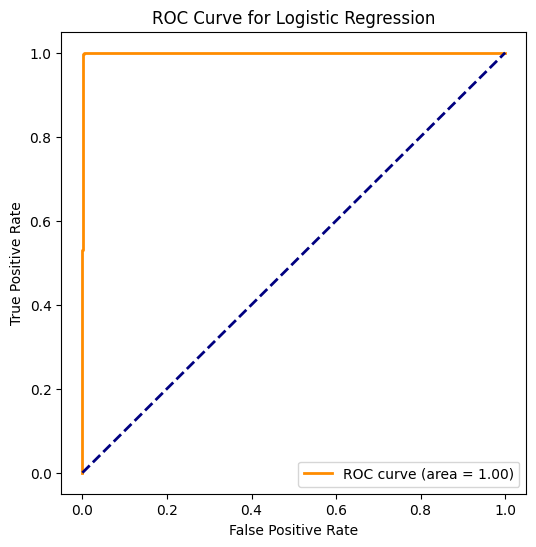


Random Forest Classifier:
Accuracy: 0.993
F1-Score: 0.9910600255427842

AdaBoost Classifier:
Accuracy: 1.0
F1-Score: 1.0

Gradient Boosting Classifier:
Accuracy: 1.0
F1-Score: 1.0

Logistic Regression Classifier:
Accuracy: 0.996
F1-Score: 0.9948586118251929

Process Completed - Time: 8:45:15.756291


In [11]:
# with different approach of preprocessing
# Handling Non-Numeric Columns:
# We identified and removed non-numeric columns from the feature set.
# While this simplifies the modeling process, consider whether these non-numeric columns could contain valuable information.
# If they do, you might want to transform them into a usable format (like one-hot encoding) instead of dropping them.
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')

overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'Mining', 'VPN', 'RemoteAccess']
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
non_numeric_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to non-numeric columns on the entire dataset
onehotencoder = OneHotEncoder()
X_encoded = onehotencoder.fit_transform(X[non_numeric_columns]).toarray()
X_encoded_df = pd.DataFrame(X_encoded, index=X.index)

# Concatenate the encoded columns back to the dataset and convert column names to strings
X = pd.concat([X.drop(non_numeric_columns, axis=1), X_encoded_df], axis=1)
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Apply preprocessing (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

# Define a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
}
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# GridSearchCV for each classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=stratified_kfold)
ab_clf = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=param_grid_ab, cv=stratified_kfold)
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gb, cv=stratified_kfold)
lr_clf = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid_lr, cv=stratified_kfold)

# Fit the classifiers
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
lr_clf.fit(X_train_scaled, y_train)
record_time("Classifiers and Hyperparameter Tuning Completed", overall_start_time)

# Print best parameters
print("Best parameters for Random Forest:", rf_clf.best_params_)
print("Best parameters for AdaBoost:", ab_clf.best_params_)
print("Best parameters for Gradient Boosting:", gb_clf.best_params_)
print("Best parameters for Logistic Regression:", lr_clf.best_params_)

# Evaluate models
classifiers = [(rf_clf.best_estimator_, 'Random Forest'), (ab_clf.best_estimator_, 'AdaBoost'), (gb_clf.best_estimator_, 'Gradient Boosting'), (lr_clf.best_estimator_, 'Logistic Regression')]
for clf, name in classifiers:
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate and print accuracy and F1-score for each model
for clf, name in classifiers:
    accuracy = accuracy_score(y_test, clf.predict(X_test_scaled))
    f1 = f1_score(y_test, clf.predict(X_test_scaled))
    print(f"\n{name} Classifier:\nAccuracy: {accuracy}\nF1-Score: {f1}")

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


